In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd #A fast, powerful, flexible and easy to use open source data analysis and manipulation tool
import numpy as np # Library for working with arrays

# creating visualizations in python
import matplotlib.pyplot as plt 
import plotly.express as px
import scipy.stats as stats
from pylab import rcParams
import seaborn as sns
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


import catboost as catt
import xgboost as xgb

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,KFold,RepeatedStratifiedKFold,train_test_split

pd.options.display.max_rows = 2200
import gc 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tz-mmu/SampleSubmission.csv
/kaggle/input/tz-mmu/Starter Notebook.ipynb
/kaggle/input/tz-mmu/Train.csv
/kaggle/input/tz-mmu/VariableDefinitions.csv
/kaggle/input/tz-mmu/Test.csv


In [66]:
!pip install datacompy
!pip install sklearn_pandas

In [67]:
!pip install pycountry_convert

In [68]:
train_set = pd.read_csv("/kaggle/input/tz-mmu/Train.csv")
test_set = pd.read_csv("/kaggle/input/tz-mmu/Test.csv")
ss = pd.read_csv("/kaggle/input/tz-mmu/SampleSubmission.csv")

In [69]:
train_set.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


In [70]:
print(train_set.shape)
print(test_set.shape)

(18506, 21)
(6169, 20)


In [71]:
## This is what you are trying to predict 
train_set.cost_category.unique()

array(['High Cost', 'Higher Cost', 'Lower Cost', 'Normal Cost',
       'Low Cost', 'Highest Cost'], dtype=object)

In [72]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

In [73]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                6169 non-null   object 
 1   country                6169 non-null   object 
 2   age_group              6169 non-null   object 
 3   travel_with            5808 non-null   object 
 4   total_female           6167 non-null   float64
 5   total_male             6168 non-null   float64
 6   purpose                6169 non-null   object 
 7   main_activity          6169 non-null   object 
 8   info_source            6169 non-null   object 
 9   tour_arrangement       6169 non-null   object 
 10  package_transport_int  6169 non-null   object 
 11  package_accomodation   6169 non-null   object 
 12  package_food           6169 non-null   object 
 13  package_transport_tz   6169 non-null   object 
 14  package_sightseeing    6169 non-null   object 
 15  pack

In [74]:
percent_missing = train_set.isnull().sum() * 100 / len(train_set)
missing_values_trainset = pd.DataFrame({'column_name': train_set.columns,
                                 'percent_missing': percent_missing})
missing_values_trainset.sort_values("percent_missing")

,column_name,percent_missing
Tour_ID,Tour_ID,0.000000
night_zanzibar,night_zanzibar,0.000000
night_mainland,night_mainland,0.000000
package_insurance,package_insurance,0.000000
package_guided_tour,package_guided_tour,0.000000
package_sightseeing,package_sightseeing,0.000000
package_transport_tz,package_transport_tz,0.000000
package_food,package_food,0.000000
package_accomodation,package_accomodation,0.000000
first_trip_tz,first_trip_tz,0.000000


In [75]:
percent_missing = test_set.isnull().sum() * 100 / len(test_set)
missing_values_testset = pd.DataFrame({'column_name': test_set.columns,
                                 'percent_missing': percent_missing})
missing_values_testset

,column_name,percent_missing
Tour_ID,Tour_ID,0.00000
country,country,0.00000
age_group,age_group,0.00000
travel_with,travel_with,5.85184
total_female,total_female,0.03242
total_male,total_male,0.01621
purpose,purpose,0.00000
main_activity,main_activity,0.00000
info_source,info_source,0.00000
tour_arrangement,tour_arrangement,0.00000


In [76]:
# categorical columns
cat_cols = [col for col in train_set.select_dtypes('object').columns]
# numerical columns
num_cols = [col for col in train_set.select_dtypes(['int', 'float']).columns]

In [77]:
# check unique values in dataset
train_set.apply(lambda x: len(x.unique()))

Tour_ID                  18506
country                    131
age_group                    5
travel_with                  6
total_female                25
total_male                  25
purpose                      8
main_activity               10
info_source                  8
tour_arrangement             2
package_transport_int        2
package_accomodation         2
package_food                 2
package_transport_tz         2
package_sightseeing          2
package_guided_tour          2
package_insurance            2
night_mainland             110
night_zanzibar              60
first_trip_tz                2
cost_category                6
dtype: int64

In [78]:
# downsample or upweight skewed/imbalanced classes

#  **Feature Engineering and EDA****

In [79]:
train_set.describe()

,total_female,total_male,night_mainland,night_zanzibar
count,18504.000000,18500.000000,18506.000000,18506.000000
mean,0.936230,0.998757,9.141576,2.493516
std,1.215582,1.173177,14.127449,5.275156
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,3.000000,0.000000
50%,1.000000,1.000000,6.000000,0.000000
75%,1.000000,1.000000,11.000000,4.000000
max,49.000000,58.000000,365.000000,240.000000


Text(0.5, 0, 'travel_with')

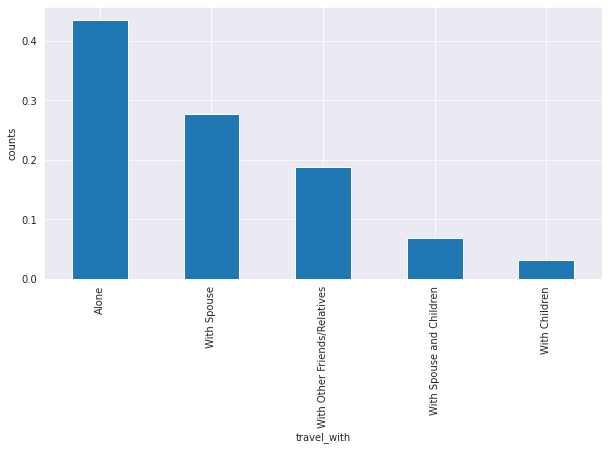

In [80]:
train_set["travel_with"].value_counts()
plt.figure(figsize=(10,5))
train_set['travel_with'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('travel_with')

In [81]:
def plot_bars(train_set, col):
    train_set[col].value_counts()
    plt.figure(figsize=(10,5))
    train_set[col].value_counts(normalize=True).plot(kind='bar')
    plt.ylabel('counts')
    plt.xlabel(str(col))

In [82]:
yesno_cols =[
"tour_arrangement",             
"package_transport_int",        
"package_accomodation",         
"package_food",                 
"package_transport_tz",         
"package_sightseeing",          
"package_guided_tour",          
"package_insurance"] 

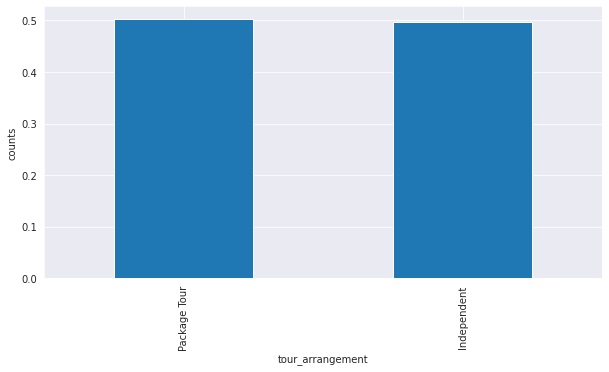

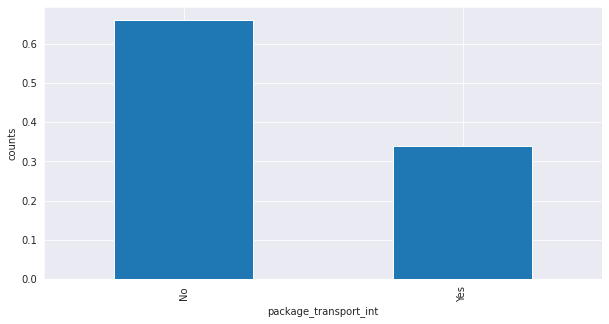

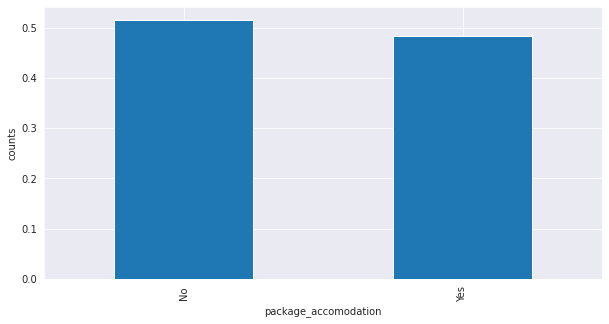

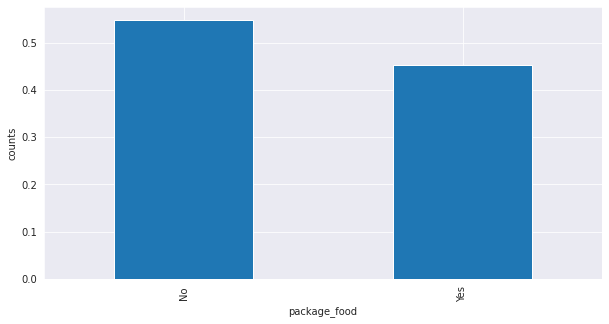

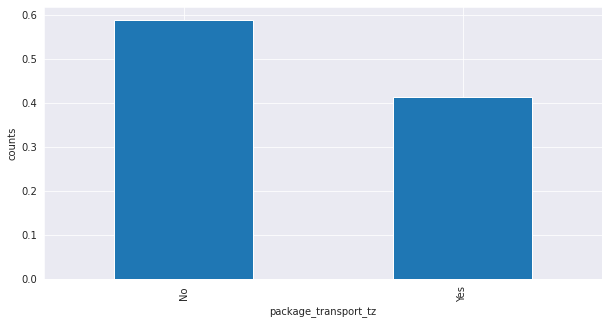

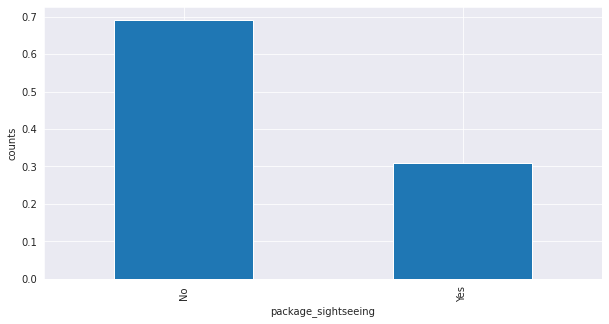

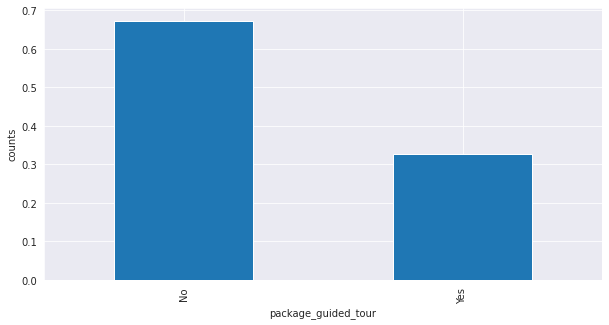

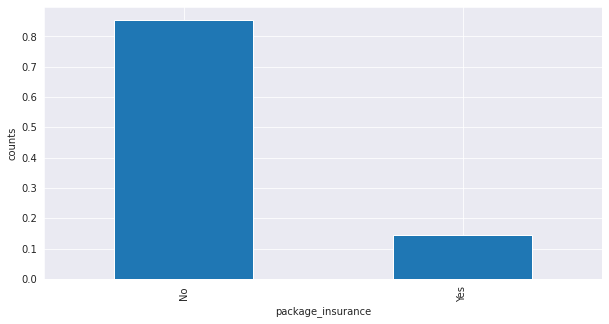

In [83]:
for i in yesno_cols:
    plot_bars(train_set, i)

In [84]:
def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

In [85]:
train_set["total_people"] = train_set["total_female"]+train_set["total_male"]
train_set["total_people"] = train_set["total_female"]+train_set["total_male"]

In [86]:
# import pycountry_convert as pc
# def convert_country(country_name):
#     country_alpha2 = pc.country_name_to_country_alpha2(country_name.title())
#     country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
# #     country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
#     return country_continent_code

In [87]:
# data['country'].replace('UNITED STATES OF AMERICA', 'NA', inplace=True)
# data["continent_cd"] = data["country"].apply(convert_country)

In [88]:
!pip install country-converter
import country_converter as coco

cc = coco.CountryConverter()
iso3 = np.array([])
for i in range(0, len(train_set)):
    iso3= np.append(iso3, cc.convert(names=train_set['country'][i], to='ISO3' ))
train_set['ISO3'] = pd.DataFrame(iso3) 
for i in range(0, len(test_set)):
    iso3= np.append(iso3, cc.convert(names=test_set['country'][i], to='ISO3' ))
test_set['ISO3'] = pd.DataFrame(iso3)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for country-converter: filename=country_converter-0.8.0-py3-none-any.whl size=55658 sha256=ddfd7410af719429c5fdd30a15857e7735dec94a9c0b44ae614ee8e6dd93ea78
  Stored in directory: /root/.cache/pip/wheels/ac/ef/42/232d7f54c493023bbf8710c3ab50939d833a2e4062afd0dea3
Successfully built country-converter


In [91]:
train_set['travel_with'] = train_set['travel_with'].fillna("Alone")
train_set["total_female"].fillna(train_set["total_female"].mean(), inplace = True)
train_set["total_male"].fillna(train_set["total_male"].mean(), inplace = True)

In [98]:
train_set["total_nights"] = train_set["night_mainland"] + train_set["night_zanzibar"]
test_set["total_nights"] = test_set["night_mainland"] + test_set["night_zanzibar"]

In [108]:
num_cols = ["age_group", "total_female", "total_male"]
corr = train_set[num_cols].corr()
corr


,total_female,total_male
total_female,1.000000,0.415186
total_male,0.415186,1.000000


In [109]:
import datacompy
compare = datacompy.Compare(train_set,test_set,join_columns='Tour_ID',
                            abs_tol=0,
                            rel_tol=0,
                            df1_name='Original', 
                            df2_name='New' )
print(compare.report())

DataComPy Comparison
--------------------

DataFrame Summary
-----------------

  DataFrame  Columns   Rows
0  Original       24  18506
1       New       22   6169

Column Summary
--------------

Number of columns in common: 22
Number of columns in Original but not in New: 2
Number of columns in New but not in Original: 0

Row Summary
-----------

Matched on: tour_id
Any duplicates on match values: No
Absolute Tolerance: 0
Relative Tolerance: 0
Number of rows in common: 0
Number of rows in Original but not in New: 18,506
Number of rows in New but not in Original: 6,169

Number of rows with some compared columns unequal: 0
Number of rows with all compared columns equal: 0

Column Comparison
-----------------

Number of columns compared with some values unequal: 0
Number of columns compared with all values equal: 22
Total number of values which compare unequal: 0

Sample Rows Only in Original (First 10 Columns)
-----------------------------------------------

               tour_id      

In [111]:
# clust = ['travel_with']
# # train = train_set.copy()
# # Separate train and test data from the combined dataframe
# train_set = data[:ntrain]
# test_set = data[ntrain:]
# ID = test_set['Tour_ID']
# # Check the shapes of the split dataset
# train_set.shape, test_set.shape

In [112]:
# from sklearn.cluster import KMeans
# for i in clust:
#     distortions = []
#     if train_set[i].dtype == object:
#         dummies = pd.get_dummies(train_set[i], drop_first=True)
#         for j in range(1, 11):
#             km = KMeans(
#                 n_clusters=j, init='k-means++',
#                 n_init=20, max_iter=300,
#                 tol=1e-04, random_state=0
#             )
#             km.fit(dummies)
#             distortions.append(km.inertia_)

#         # plot
#         print(i, km.inertia_)
#         plt.plot(range(1, 11), distortions, marker='o')
#         plt.xlabel('Number of clusters')
#         plt.ylabel('Distortion')
#         plt.show()
    
#     else:
#         for j in range(1, 11):
#             km = KMeans(
#                 n_clusters=j, init='k-means++',
#                 n_init=20, max_iter=300,
#                 tol=1e-04, random_state=0
#             )
#             km.fit(pd.DataFrame(train_set[i]))
#             distortions.append(km.inertia_)

#         # plot

#         print(i, km.inertia_)
#         plt.plot(range(1, 11), distortions, marker='o')
#         plt.xlabel('Number of clusters')
#         plt.ylabel('Distortion')
#         plt.show()


In [113]:
# kmeans = KMeans(
#         n_clusters=5, init='k-means++',
#         n_init=20, max_iter=300,
#         tol=1e-04, random_state=0
#     )

In [114]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_columns = [col for col in data.select_dtypes('object').columns if col not in ['Tour_ID','cost_category']]

for col in le_columns:
   data[col] = le.fit_transform(data[col])

In [115]:
# %%capture 


# for col in clust:
#     if train_set[col].dtype == object:
#         dummies = pd.get_dummies(train_set[col], drop_first=True)
#         test_dum = pd.get_dummies(test_set[col], drop_first=True)
#         kmeans.fit(dummies)
#         train_set[col+'_grouped'] = kmeans.labels_
#         test_set[col+'_grouped'] = kmeans.predict(test_dum)
#     else:
#         kmeans.fit(pd.DataFrame(train[col]))
#         train_set[col+'_grouped'] = kmeans.labels_
#         test_set[col+'_grouped'] = kmeans.predict(pd.DataFrame(test[col]))

In [116]:
data = pd.concat((train_set, test_set)).reset_index(drop=True)
data = pd.get_dummies(data, columns = [
 'age_group','main_activity','package_transport_int','first_trip_tz',
])
data.head(10)

,tour_id,country,travel_with,total_female,total_male,purpose,info_source,tour_arrangement,package_accomodation,package_food,...,main_activity_Cultural Tourism,main_activity_Diving and Sport Fishing,main_activity_Hunting Tourism,main_activity_Mountain Climbing,main_activity_Widlife Tourism,main_activity_Wildlife Tourism,package_transport_int_No,package_transport_int_Yes,first_trip_tz_No,first_trip_tz_Yes
0,tour_id1hffseyw,ITALY,With Children,0.0,2.0,Visiting Friends and Relatives,"Friends, relatives",Package Tour,Yes,Yes,...,0,0,0,0,0,0,0,1,0,1
1,tour_idnacd7zag,UNITED KINGDOM,With Spouse,1.0,1.0,Leisure and Holidays,"Travel agent, tour operator",Package Tour,Yes,Yes,...,0,0,0,0,0,1,0,1,0,1
2,tour_id62vz7e71,UNITED STATES OF AMERICA,With Spouse,1.0,1.0,Leisure and Holidays,"Travel agent, tour operator",Package Tour,Yes,Yes,...,0,0,0,0,1,0,0,1,0,1
3,tour_idrc76tzix,RWANDA,With Spouse and Children,3.0,1.0,Leisure and Holidays,"Radio, TV, Web",Independent,No,No,...,0,0,0,0,0,0,1,0,1,0
4,tour_idn723m0n9,UNITED STATES OF AMERICA,Alone,0.0,1.0,Leisure and Holidays,"Travel agent, tour operator",Package Tour,Yes,Yes,...,0,0,0,0,1,0,0,1,0,1
5,tour_id8aylf7ba,FRANCE,With Spouse,1.0,1.0,Leisure and Holidays,"Newspaper, magazines, brochures",Package Tour,Yes,Yes,...,0,0,0,0,1,0,0,1,0,1
6,tour_idvcadicba,SWIZERLAND,With Spouse,1.0,1.0,Leisure and Holidays,"Newspaper, magazines, brochures",Independent,No,No,...,0,0,0,0,0,1,1,0,0,1
7,tour_idfmavssxv,NIGERIA,Alone,0.0,1.0,Leisure and Holidays,"Travel agent, tour operator",Independent,No,No,...,1,0,0,0,0,0,1,0,0,1
8,tour_id8oqlvjwr,UNITED KINGDOM,Alone,1.0,0.0,Leisure and Holidays,"Friends, relatives",Independent,No,No,...,1,0,0,0,0,0,1,0,0,1
9,tour_idy0blevrs,AUSTRALIA,With Spouse,1.0,1.0,Leisure and Holidays,"Travel agent, tour operator",Package Tour,Yes,No,...,0,0,0,0,1,0,0,1,0,1


In [123]:
# Separate train and test data from the combined dataframe
train_df = train_set
test_df = test_set
ID = test_df['tour_id']
# Check the shapes of the split dataset
train_df.shape, test_df.shape

KeyError: 'Tour_ID'

In [ ]:
le_columns = ['cost_category']
for col in le_columns:
   train_df[col] = le.fit_transform(train_df[col])

In [ ]:
# Select main columns to be used in training
main_cols = train_df.columns.difference(['Tour_ID','cost_category',
 'package_accomodation','tour_arrangement','travel_with',
 'package_food'])
X = train_df[main_cols]
y = train_df.cost_category

****Modelling**

In [ ]:
from imblearn.over_sampling import  RandomOverSampler
fold_pred=[]
oof_pred = []

params = {'lambda': 0.07151347287471778,
          'alpha': 0.0014616817885847832,
                       'colsample_bytree': 0.3,
                       'subsample': 0.6,
                       'learning_rate': 0.008,
                       'max_depth': 11,
                       'random_state': 2020,
                       'min_child_weight': 133
                      }
 




fold= StratifiedKFold(n_splits=3)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    model = catt.CatBoostClassifier(bootstrap_type='Bernoulli', task_type='CPU')

    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=250, verbose = False)#erly100

    preds= model.predict_proba(X_test)
    print("err: ",(log_loss(y_test,preds)))  
    oof_pred.append(log_loss(y_test,preds))
    p2 = model.predict_proba(test_df[X.columns])
    fold_pred.append(p2)
    

print(np.mean(oof_pred)) 

In [ ]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df
#
get_catt_varimp(model, X.columns)

In [ ]:
test_df[['a','b','c','d','e','f']] = model.predict_proba(test_df[X.columns])

submission = pd.DataFrame({"ID": ID,
                           "High Cost": test_df['a'],
                           "Higher Cost": test_df['b'],
                           "Highest Cost": test_df['c'],
                           "Low Cost": test_df['d'],
                           "Lower Cost": test_df['e'],
                           "Normal Cost": test_df['f']
                          })
submission.to_csv('sub5.csv',index=False)
submission.head()

In [ ]:
# def objective(trial):
#     fold_pred=[]
#     oof_pred = []


#     param = {
 
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
#         'n_estimators': 10000,
#         'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
#         'random_state': trial.suggest_categorical('random_state', [2020]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#     }
    




#     fold= StratifiedKFold(n_splits=3)#15#5#10
#     i=1
#     for train_index, test_index in fold.split(X,y):     

#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
# # 

#         model = catt.CatBoostClassifier(bootstrap_type='Bernoulli', task_type='CPU')

#         model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=250, verbose = False)#erly100

#         preds= model.predict_proba(X_test)
#         print("err: ",(log_loss(y_test,preds)))  
#         oof_pred.append(log_loss(y_test,preds))
#         p2 = model.predict_proba(test_df[X.columns])
#         fold_pred.append(p2)


#     return np.mean(oof_pred) 

In [ ]:
# import optuna
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)